In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import pyspark.sql.types as T

from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import DecisionTreeClassifier,NaiveBayes,LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# import nltk
# from nltk.corpus import stopwords
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import NGram,OneHotEncoder, StringIndexer, VectorAssembler

In [3]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [4]:
spark = SparkSession.builder \
    .appName("text_classification_trainer") \
    .master("local") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/27 18:04:45 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/04/27 18:04:45 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/04/27 18:04:45 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/04/27 18:04:45 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [5]:
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import NGram,OneHotEncoder, StringIndexer, VectorAssembler
from itertools import combinations

In [7]:
df = spark.read.csv("gs://bdl2023-final-proj/YELP_train.csv")

In [8]:
df = df.withColumn("_c1", col("_c1").cast("int"))
df = df.withColumn("_c3", col("_c3").cast("int"))
df = df.withColumn("_c5", col("_c5").cast("int"))
df = df.withColumn("_c7", col("_c7").cast("int"))

In [9]:
df.show()

+--------------------+----+--------------------+----+--------------------+----+--------------------+----+--------------------+
|                 _c0| _c1|                 _c2| _c3|                 _c4| _c5|                 _c6| _c7|                 _c8|
+--------------------+----+--------------------+----+--------------------+----+--------------------+----+--------------------+
|--30_8IhuyMHbSOcN...|   0| 2018-04-30 16:56:24|   0|DBJXMz1RIr91eFUd0...|   4|My child has been...|   1|LH2QmlXtq8CLji65l...|
|--7PUidqRWpRSpXeb...|   0| 2019-11-02 23:30:02|   0|0O4RqD91ZHdCPw4rU...|   1|Lunchtime while v...|null|                null|
|The exterior and ...|null|                null|null|                null|null|                null|null|                null|
|Drug use action j...|null|                null|null|                null|null|                null|null|                null|
|Pan scrambler was...|null|                null|null|                null|null|                null|null|      

In [10]:
df = df.dropna(subset = ['_c5'])

In [11]:
null_counts = df.agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

In [12]:
null_counts.show()

+---+-----+---+-----+---+---+---+-------+-------+
|_c0|  _c1|_c2|  _c3|_c4|_c5|_c6|    _c7|    _c8|
+---+-----+---+-----+---+---+---+-------+-------+
|  5|66106| 55|66090|  0|  0| 34|1998376|1998306|
+---+-----+---+-----+---+---+---+-------+-------+



In [13]:
df = df.dropna(subset = ['_c6'])

In [14]:
null_counts = df.agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
null_counts.show()

+---+-----+---+-----+---+---+---+-------+-------+
|_c0|  _c1|_c2|  _c3|_c4|_c5|_c6|    _c7|    _c8|
+---+-----+---+-----+---+---+---+-------+-------+
|  5|66073| 55|66059|  0|  0|  0|1998342|1998272|
+---+-----+---+-----+---+---+---+-------+-------+



In [15]:
!pip install tabulate

In [17]:
df = df.drop('_c4','_c8','_c0')

In [19]:
df = df.withColumn("_c2", to_timestamp("_c2", "yyyy-MM-dd HH:mm:ss"))

In [21]:
df = df.withColumn("hour", hour("_c2"))
df = df.withColumn("category", when((df.hour >= 6) & (df.hour < 12), "morning")
                           .when((df.hour >= 12) & (df.hour < 18), "afternoon")
                           .when((df.hour >= 18) & (df.hour < 22), "evening")
                           .otherwise("night"))

# drop "hour" column
df = df.drop("hour")

# show resulting DataFrame
df.show()

+---+-------------------+---+---+--------------------+----+---------+
|_c1|                _c2|_c3|_c5|                 _c6| _c7| category|
+---+-------------------+---+---+--------------------+----+---------+
|  0|2018-04-30 16:56:24|  0|  4|My child has been...|   1|afternoon|
|  0|2019-11-02 23:30:02|  0|  1|Lunchtime while v...|null|    night|
|  0|2015-06-16 02:10:33|  0|  2|Eh.. not that gre...|   6|    night|
|  0|2015-08-20 00:18:26|  0|  1|4706 Paris Ave, N...|   0|    night|
|  0|2019-03-14 15:52:59|  0|  5|We recently had o...|   0|afternoon|
|  0|2019-03-29 22:31:53|  0|  1|Very poor experie...|   0|    night|
|  0|2020-12-12 01:47:09|  0|  3|Eh, the place isn...|   0|    night|
|  0|2021-09-09 11:53:11|  0|  1|"Pool is Green an...|null|  morning|
|  0|2021-10-06 02:28:21|  0|  5|Stayed there a mo...|   0|    night|
|  0|2019-08-09 21:11:02|  0|  5|Amazing service a...|   0|  evening|
|  0|2020-12-07 17:44:32|  0|  5|Tim was extremely...|   0|afternoon|
|  0|2021-05-20 18:3

In [22]:
df = df.withColumn("year", year("_c2"))
df.show()

+---+-------------------+---+---+--------------------+----+---------+----+
|_c1|                _c2|_c3|_c5|                 _c6| _c7| category|year|
+---+-------------------+---+---+--------------------+----+---------+----+
|  0|2018-04-30 16:56:24|  0|  4|My child has been...|   1|afternoon|2018|
|  0|2019-11-02 23:30:02|  0|  1|Lunchtime while v...|null|    night|2019|
|  0|2015-06-16 02:10:33|  0|  2|Eh.. not that gre...|   6|    night|2015|
|  0|2015-08-20 00:18:26|  0|  1|4706 Paris Ave, N...|   0|    night|2015|
|  0|2019-03-14 15:52:59|  0|  5|We recently had o...|   0|afternoon|2019|
|  0|2019-03-29 22:31:53|  0|  1|Very poor experie...|   0|    night|2019|
|  0|2020-12-12 01:47:09|  0|  3|Eh, the place isn...|   0|    night|2020|
|  0|2021-09-09 11:53:11|  0|  1|"Pool is Green an...|null|  morning|2021|
|  0|2021-10-06 02:28:21|  0|  5|Stayed there a mo...|   0|    night|2021|
|  0|2019-08-09 21:11:02|  0|  5|Amazing service a...|   0|  evening|2019|
|  0|2020-12-07 17:44:32|

In [23]:
df = df.withColumn("day_of_week", dayofweek(df._c2))


In [26]:
# df = df.drop('_c2')
df = df.drop('weekday')
# df = df.withColumn("day", col("weekday").cast(StringType()))

In [27]:
df = df.withColumn("is_weekend", when((df.day_of_week == 1) | (df.day_of_week == 7), 1)
                           .otherwise(0))

In [28]:
df.show()

+---+-------------------+---+---+--------------------+----+---------+----+-----------+----------+
|_c1|                _c2|_c3|_c5|                 _c6| _c7| category|year|day_of_week|is_weekend|
+---+-------------------+---+---+--------------------+----+---------+----+-----------+----------+
|  0|2018-04-30 16:56:24|  0|  4|My child has been...|   1|afternoon|2018|          2|         0|
|  0|2019-11-02 23:30:02|  0|  1|Lunchtime while v...|null|    night|2019|          7|         1|
|  0|2015-06-16 02:10:33|  0|  2|Eh.. not that gre...|   6|    night|2015|          3|         0|
|  0|2015-08-20 00:18:26|  0|  1|4706 Paris Ave, N...|   0|    night|2015|          5|         0|
|  0|2019-03-14 15:52:59|  0|  5|We recently had o...|   0|afternoon|2019|          5|         0|
|  0|2019-03-29 22:31:53|  0|  1|Very poor experie...|   0|    night|2019|          6|         0|
|  0|2020-12-12 01:47:09|  0|  3|Eh, the place isn...|   0|    night|2020|          7|         1|
|  0|2021-09-09 11:5

In [29]:
df.dtypes

[('_c1', 'int'),
 ('_c2', 'timestamp'),
 ('_c3', 'int'),
 ('_c5', 'int'),
 ('_c6', 'string'),
 ('_c7', 'int'),
 ('category', 'string'),
 ('year', 'int'),
 ('day_of_week', 'int'),
 ('is_weekend', 'int')]

In [30]:
indexer_day = StringIndexer(inputCol="category", outputCol="part_of_day")
# indexer_weekend = StringIndexer(inputCol="day", outputCol="day_category")
df = indexer_day.fit(df).transform(df)
# df = indexer_weekend.fit(df).transform(df)
df.show()

+---+-------------------+---+---+--------------------+----+---------+----+-----------+----------+-----------+
|_c1|                _c2|_c3|_c5|                 _c6| _c7| category|year|day_of_week|is_weekend|part_of_day|
+---+-------------------+---+---+--------------------+----+---------+----+-----------+----------+-----------+
|  0|2018-04-30 16:56:24|  0|  4|My child has been...|   1|afternoon|2018|          2|         0|        1.0|
|  0|2019-11-02 23:30:02|  0|  1|Lunchtime while v...|null|    night|2019|          7|         1|        0.0|
|  0|2015-06-16 02:10:33|  0|  2|Eh.. not that gre...|   6|    night|2015|          3|         0|        0.0|
|  0|2015-08-20 00:18:26|  0|  1|4706 Paris Ave, N...|   0|    night|2015|          5|         0|        0.0|
|  0|2019-03-14 15:52:59|  0|  5|We recently had o...|   0|afternoon|2019|          5|         0|        1.0|
|  0|2019-03-29 22:31:53|  0|  1|Very poor experie...|   0|    night|2019|          6|         0|        0.0|
|  0|2020-

In [31]:
df = df.withColumn("month", month("_c2"))
df.show()

+---+-------------------+---+---+--------------------+----+---------+----+-----------+----------+-----------+-----+
|_c1|                _c2|_c3|_c5|                 _c6| _c7| category|year|day_of_week|is_weekend|part_of_day|month|
+---+-------------------+---+---+--------------------+----+---------+----+-----------+----------+-----------+-----+
|  0|2018-04-30 16:56:24|  0|  4|My child has been...|   1|afternoon|2018|          2|         0|        1.0|    4|
|  0|2019-11-02 23:30:02|  0|  1|Lunchtime while v...|null|    night|2019|          7|         1|        0.0|   11|
|  0|2015-06-16 02:10:33|  0|  2|Eh.. not that gre...|   6|    night|2015|          3|         0|        0.0|    6|
|  0|2015-08-20 00:18:26|  0|  1|4706 Paris Ave, N...|   0|    night|2015|          5|         0|        0.0|    8|
|  0|2019-03-14 15:52:59|  0|  5|We recently had o...|   0|afternoon|2019|          5|         0|        1.0|    3|
|  0|2019-03-29 22:31:53|  0|  1|Very poor experie...|   0|    night|201

In [32]:
df = df.drop('_c2')
df = df.drop('category')

In [33]:
df.show()

+---+---+---+--------------------+----+----+-----------+----------+-----------+-----+
|_c1|_c3|_c5|                 _c6| _c7|year|day_of_week|is_weekend|part_of_day|month|
+---+---+---+--------------------+----+----+-----------+----------+-----------+-----+
|  0|  0|  4|My child has been...|   1|2018|          2|         0|        1.0|    4|
|  0|  0|  1|Lunchtime while v...|null|2019|          7|         1|        0.0|   11|
|  0|  0|  2|Eh.. not that gre...|   6|2015|          3|         0|        0.0|    6|
|  0|  0|  1|4706 Paris Ave, N...|   0|2015|          5|         0|        0.0|    8|
|  0|  0|  5|We recently had o...|   0|2019|          5|         0|        1.0|    3|
|  0|  0|  1|Very poor experie...|   0|2019|          6|         0|        0.0|    3|
|  0|  0|  3|Eh, the place isn...|   0|2020|          7|         1|        0.0|   12|
|  0|  0|  1|"Pool is Green an...|null|2021|          5|         0|        3.0|    9|
|  0|  0|  5|Stayed there a mo...|   0|2021|          

In [34]:
df = df.withColumnRenamed('_c5','rating')
df = df.withColumnRenamed('_c6','review')

df.show()

+---+---+------+--------------------+----+----+-----------+----------+-----------+-----+
|_c1|_c3|rating|              review| _c7|year|day_of_week|is_weekend|part_of_day|month|
+---+---+------+--------------------+----+----+-----------+----------+-----------+-----+
|  0|  0|     4|My child has been...|   1|2018|          2|         0|        1.0|    4|
|  0|  0|     1|Lunchtime while v...|null|2019|          7|         1|        0.0|   11|
|  0|  0|     2|Eh.. not that gre...|   6|2015|          3|         0|        0.0|    6|
|  0|  0|     1|4706 Paris Ave, N...|   0|2015|          5|         0|        0.0|    8|
|  0|  0|     5|We recently had o...|   0|2019|          5|         0|        1.0|    3|
|  0|  0|     1|Very poor experie...|   0|2019|          6|         0|        0.0|    3|
|  0|  0|     3|Eh, the place isn...|   0|2020|          7|         1|        0.0|   12|
|  0|  0|     1|"Pool is Green an...|null|2021|          5|         0|        3.0|    9|
|  0|  0|     5|Staye

In [35]:
# df = df.withColumn("part_of_day", col("part_of_day").cast("int"))
# df = df.withColumn("day_category", col("day_category").cast("int"))

In [36]:
df.dtypes

[('_c1', 'int'),
 ('_c3', 'int'),
 ('rating', 'int'),
 ('review', 'string'),
 ('_c7', 'int'),
 ('year', 'int'),
 ('day_of_week', 'int'),
 ('is_weekend', 'int'),
 ('part_of_day', 'double'),
 ('month', 'int')]

In [37]:
# yelp_corr = df.select(['_c1', '_c3', 'rating','_c7','year', 'is_weekend','part_of_day','day_of_week','month'])
# yelp_corr.stat.corr('_c1','day_of_week')

-0.001820469200110699

In [38]:
for col_name in df.columns:
    try:
        median_value = df.approxQuantile(col_name, [0.5], 0.01)[0]
        df = df.fillna(median_value, subset=[col_name])
    except:
        pass

In [39]:
df.columns

['_c1',
 '_c3',
 'rating',
 'review',
 '_c7',
 'year',
 'day_of_week',
 'is_weekend',
 'part_of_day',
 'month']

In [40]:
from pyspark.ml.feature import VectorAssembler
vector_col = 'corr_features'

assembler = VectorAssembler(inputCols = ['_c1',
 '_c3',
 'rating',
 '_c7',
 'year',
 'day_of_week',
 'is_weekend',
 'part_of_day',
 'month'], outputCol = vector_col)

In [41]:
df_vector = assembler.transform(df).select(vector_col)

In [42]:
# matrix = Correlation.corr(df_vector,vector_col).collect()[0][0]

23/04/25 05:14:57 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/25 05:14:57 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [43]:
# corrmatrix = matrix.toArray().tolist()

In [44]:
# columns = [col for col in df.columns if col != 'review']

# df_corr = spark.createDataFrame(corrmatrix,columns)

In [45]:
# df_corr.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 _c1|                 _c3|              rating|                 _c7|                year|         day_of_week|          is_weekend|         part_of_day|               month|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0| 0.03781650493858897| 0.03279499949099988| 0.13630807617584742|-0.01658007376381114|-0.00216190557314...|-0.01134737122335...|0.003997439186418...|-0.00334703574034...|
| 0.03781650493858897|                 1.0|  0.9801795720427717|0.005945384142506707|-0.00417876339791...|-1.28096509255356...|-0.00123808379294...|1.116785989962987...|-2.27710775947134...|
| 0.03279499949099988|  0.9801795720427717|  

/tmp/ipykernel_8879/3401361723.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
/tmp/ipykernel_8879/3401361723.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


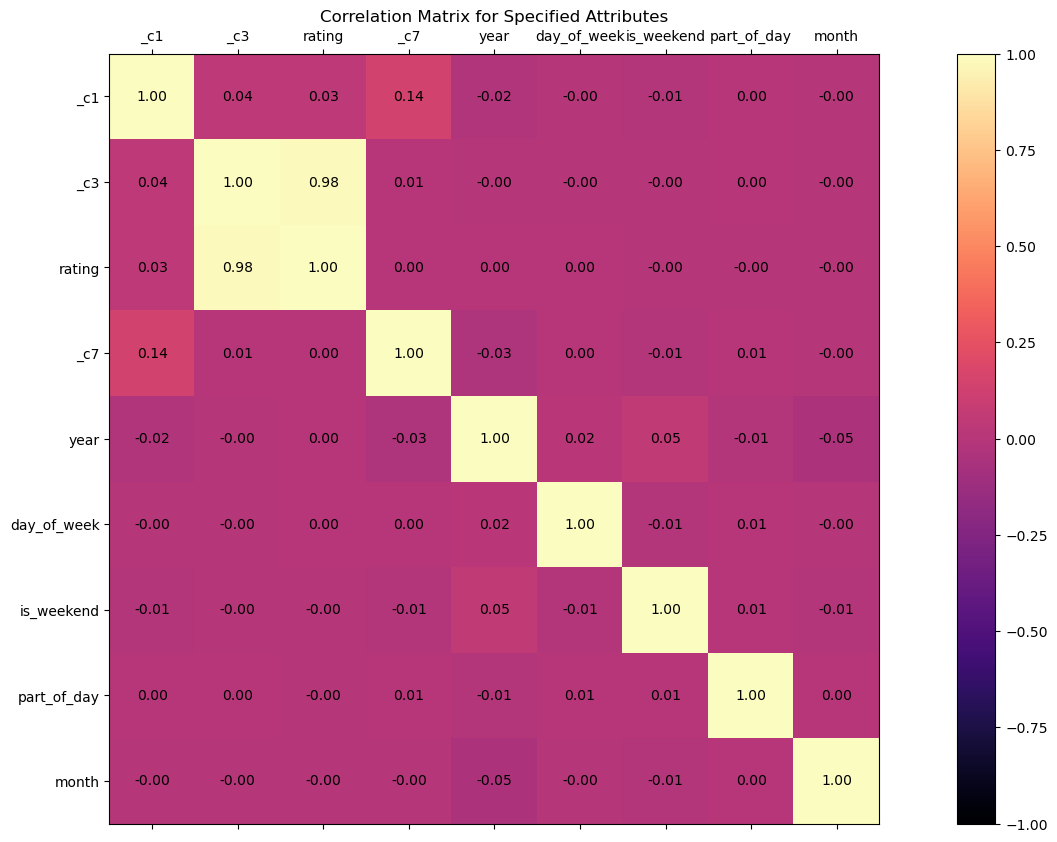

In [46]:
# import matplotlib.pyplot as plt

# def plot_corr_matrix(correlations,attr,fig_no):
#     fig=plt.figure(figsize = (20,10))
#     ax=fig.add_subplot(111)
#     ax.set_title("Correlation Matrix for Specified Attributes")
#     ax.set_xticklabels(['']+attr)
#     ax.set_yticklabels(['']+attr)
#     cax=ax.matshow(correlations,vmax=1,vmin=-1,cmap='magma')
#     fig.colorbar(cax)
    
#     for i in range(len(attr)):
#         for j in range(len(attr)):
#             ax.annotate('{:.2f}'.format(correlations[i][j]), xy=(j, i), ha='center', va='center')
    
#     plt.show()

# plot_corr_matrix(corrmatrix, columns, 234)


In [41]:
# yelp_corr = df.select(['_c1', '_c3', 'rating','_c7','year', 'is_weekend','part_of_day','day_category','month'])

# c11, c12 = yelp_corr.stat.corr('_c1', '_c1'), yelp_corr.stat.corr('_c1', '_c3')
# c13, c14, c15,c16,c17,c18,c19 = yelp_corr.stat.corr('_c1', 'rating'), yelp_corr.stat.corr('_c1', '_c7'), yelp_corr.stat.corr('_c1','year'),yelp_corr.stat.corr('_c1','is_weekend'),yelp_corr.stat.corr('_c1','part_of_day'),yelp_corr.stat.corr('_c1','day_category'),yelp_corr.stat.corr('_c1','month')
# c21, c22 = c12, c11
# c23, c24, c25,c26,c27,c28,c29= yelp_corr.stat.corr('_c3', 'rating'), yelp_corr.stat.corr('_c3', '_c7'), yelp_corr.stat.corr('_c3','year'),yelp_corr.stat.corr('_c3','is_weekend'),yelp_corr.stat.corr('_c3','part_of_day'),yelp_corr.stat.corr('_c3','day_category'),yelp_corr.stat.corr('_c3','month')
# c31, c32 = c13, c23
# c33, c34, c35,c36,c37,c38,c39 = yelp_corr.stat.corr('rating', 'rating'), yelp_corr.stat.corr('rating', '_c7'), yelp_corr.stat.corr('rating','year'),yelp_corr.stat.corr('rating','is_weekend'),yelp_corr.stat.corr('rating','part_of_day'),yelp_corr.stat.corr('rating','day_category'),yelp_corr.stat.corr('rating','month')
# c41, c42 = c14, c24
# c43, c44, c45,c46,c47,c48,c49 = yelp_corr.stat.corr('_c7', 'rating'), yelp_corr.stat.corr('_c7', '_c7'), yelp_corr.stat.corr('_c7','year'),yelp_corr.stat.corr('_c7','is_weekend'),yelp_corr.stat.corr('_c7','part_of_day'),yelp_corr.stat.corr('_c7','day_category'),yelp_corr.stat.corr('_c7','month')
# c51, c52 = c15, c25
# c53, c54, c55,c56,c57,c58,c59 = yelp_corr.stat.corr('year', 'rating'), yelp_corr.stat.corr('year', '_c7'), yelp_corr.stat.corr('year','year'),yelp_corr.stat.corr('year','is_weekend'),yelp_corr.stat.corr('year','part_of_day'),yelp_corr.stat.corr('year','day_category'),yelp_corr.stat.corr('year','month')
# c61, c62 = c16, c26
# c63, c64, c65,c66,c67,c68,c69 = yelp_corr.stat.corr('is_weekend', 'rating'), yelp_corr.stat.corr('is_weekend', '_c7'), yelp_corr.stat.corr('is_weekend','year'),yelp_corr.stat.corr('is_weekend','is_weekend'),yelp_corr.stat.corr('is_weekend','part_of_day'),yelp_corr.stat.corr('is_weekend','day_category'),yelp_corr.stat.corr('is_weekend','month')
# c71, c72 = c17, c27
# c73, c74, c75,c76,c77,c78,c79 = yelp_corr.stat.corr('part_of_day', 'rating'), yelp_corr.stat.corr('part_of_day', '_c7'), yelp_corr.stat.corr('part_of_day','year'),yelp_corr.stat.corr('part_of_day','is_weekend'),yelp_corr.stat.corr('part_of_day','part_of_day'),yelp_corr.stat.corr('part_of_day','day_category'),yelp_corr.stat.corr('part_of_day','month')
# c81, c82 = c18, c28
# c83, c84, c85,c86,c87,c88,c89 = yelp_corr.stat.corr('day_category', 'rating'), yelp_corr.stat.corr('day_category', '_c7'), yelp_corr.stat.corr('day_category','year'),yelp_corr.stat.corr('day_category','is_weekend'),yelp_corr.stat.corr('day_category','part_of_day'),yelp_corr.stat.corr('day_category','day_category'),yelp_corr.stat.corr('day_category','month')
# c91, c92 = c19, c29
# c93, c94, c95,c96,c97,c98,c99 = yelp_corr.stat.corr('month', 'rating'), yelp_corr.stat.corr('month', '_c7'), yelp_corr.stat.corr('month','year'),yelp_corr.stat.corr('month','is_weekend'),yelp_corr.stat.corr('month','part_of_day'),yelp_corr.stat.corr('month','day_category'),yelp_corr.stat.corr('month','month')


23/04/23 11:01:16 ERROR org.apache.spark.executor.Executor: Exception in task 0.0 in stage 76.0 (TID 1218)
org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3543/1904735539: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.foreach(WholeStageCodegenExec.scala:753)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.

Py4JJavaError: An error occurred while calling o544.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 76.0 failed 1 times, most recent failure: Lost task 0.0 in stage 76.0 (TID 1218) (cluster-45cd-m.c.be19b018.internal executor driver): org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3543/1904735539: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.foreach(WholeStageCodegenExec.scala:753)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.foldLeft(WholeStageCodegenExec.scala:753)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.aggregate(WholeStageCodegenExec.scala:753)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:902)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2204)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2299)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1222)
	at org.apache.spark.sql.execution.stat.StatFunctions$.collectStatisticalData(StatFunctions.scala:162)
	at org.apache.spark.sql.execution.stat.StatFunctions$.pearsonCorrelation(StatFunctions.scala:109)
	at org.apache.spark.sql.DataFrameStatFunctions.corr(DataFrameStatFunctions.scala:159)
	at sun.reflect.GeneratedMethodAccessor157.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3543/1904735539: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.foreach(WholeStageCodegenExec.scala:753)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.foldLeft(WholeStageCodegenExec.scala:753)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.aggregate(WholeStageCodegenExec.scala:753)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 32 more


In [47]:
df.dtypes

[('_c1', 'int'),
 ('_c3', 'int'),
 ('rating', 'int'),
 ('review', 'string'),
 ('_c7', 'int'),
 ('year', 'int'),
 ('day_of_week', 'int'),
 ('is_weekend', 'int'),
 ('part_of_day', 'double'),
 ('month', 'int')]

In [71]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.stat import Correlation

# # select relevant columns from dataframe
# cols = ['_c1', '_c3', 'rating', '_c7', 'year', 'is_weekend', 'part_of_day', 'day_category', 'month']
# df_corr = df.select(cols)

# # assemble columns into a vector
# assembler = VectorAssembler(inputCols=cols, outputCol="features")
# df_corr = assembler.transform(df_corr).select("features")

# # compute correlation matrix
# matrix = Correlation.corr(df_corr, "features").head()

# # extract correlations as a numpy array
# correlations = matrix[0].toArray()


23/04/23 10:08:41 ERROR org.apache.spark.executor.Executor: Exception in task 0.0 in stage 70.0 (TID 869)
org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3595/674347533: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterat

Py4JJavaError: An error occurred while calling z:org.apache.spark.ml.stat.Correlation.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 70.0 failed 1 times, most recent failure: Lost task 0.0 in stage 70.0 (TID 869) (cluster-45cd-m.c.be19b018.internal executor driver): org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3595/674347533: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 36 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:902)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2204)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2299)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1177)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1222)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeCovariance(RowMatrix.scala:436)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationMatrix(PearsonCorrelation.scala:49)
	at org.apache.spark.mllib.stat.correlation.Correlations$.corrMatrix(Correlation.scala:66)
	at org.apache.spark.mllib.stat.Statistics$.corr(Statistics.scala:90)
	at org.apache.spark.ml.stat.Correlation$.corr(Correlation.scala:71)
	at org.apache.spark.ml.stat.Correlation.corr(Correlation.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3595/674347533: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$3(RDD.scala:1230)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$5(RDD.scala:1231)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 36 more


In [48]:
# r1 = [c11, c12, c13, c14, c15]
# r2 = [c21, c22, c23, c24, c25]
# r3 = [c31, c32, c33, c34, c35]
# r4 = [c41, c42, c43, c44, c45]
# r5 = [c51, c52, c53, c54, c55]

NameError: name 'c11' is not defined

/tmp/ipykernel_11176/2610732704.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_11176/2610732704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


Text(0.5, 1.0, 'Correlation matrix for the features in the yelp dataset')

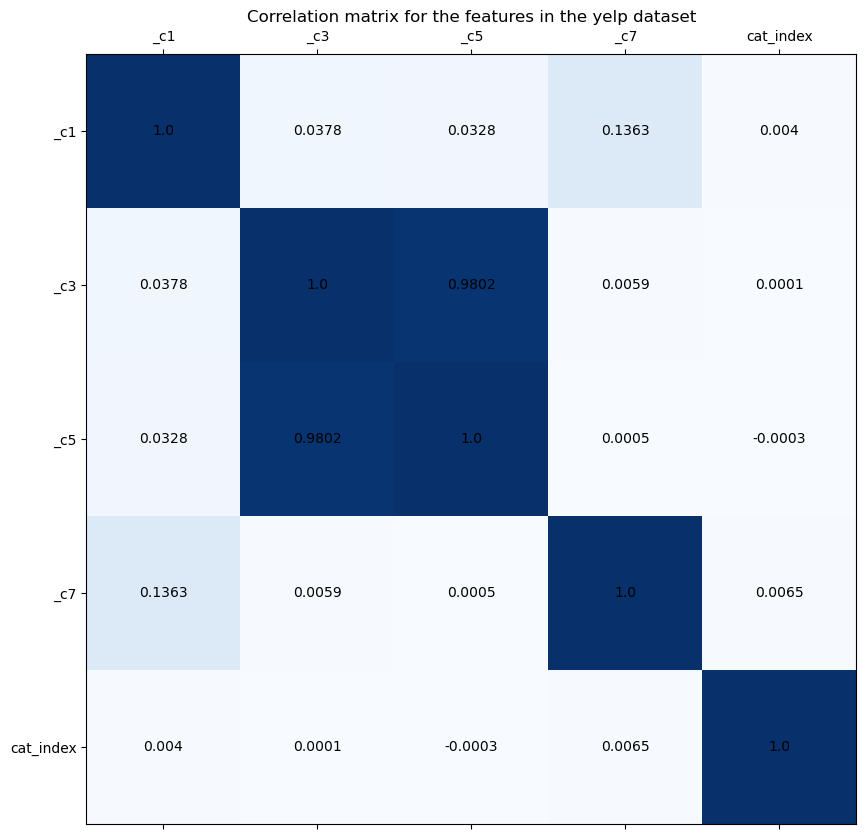

In [104]:
# import numpy as np
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize = (10,10))

# corr_matrix = np.array([r1, r2, r3, r4, r5])
# num2col = {0:'_c1', 1:'_c3', 2:'_c5', 3:'_c7', 4: '_cat_index'}
# ax.matshow(corr_matrix, cmap=plt.cm.Blues)
# labels = ['_c1', '_c3', '_c5', '_c7', 'cat_index']
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)

# for i in range(5):
#     for j in range(5):
#         c = corr_matrix[j, i].round(4)
#         ax.text(i, j, str(c), va='center', ha='center')
    
# plt.title('Correlation matrix for the features in the yelp dataset')


In [51]:
null_counts = df.agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df
                    .columns])

In [52]:
null_counts.show()

+---+---+------+------+---+----+-----------+----------+-----------+-----+
|_c1|_c3|rating|review|_c7|year|day_of_week|is_weekend|part_of_day|month|
+---+---+------+------+---+----+-----------+----------+-----------+-----+
|  0|  0|     0|     0|  0|   0|          0|         0|          0|    0|
+---+---+------+------+---+----+-----------+----------+-----------+-----+



In [53]:
# df.show()

+---+---+------+--------------------+---+----+-----------+----------+-----------+-----+
|_c1|_c3|rating|              review|_c7|year|day_of_week|is_weekend|part_of_day|month|
+---+---+------+--------------------+---+----+-----------+----------+-----------+-----+
|  0|  0|     4|My child has been...|  1|2018|          2|         0|        1.0|    4|
|  0|  0|     1|Lunchtime while v...|  0|2019|          7|         1|        0.0|   11|
|  0|  0|     2|Eh.. not that gre...|  6|2015|          3|         0|        0.0|    6|
|  0|  0|     1|4706 Paris Ave, N...|  0|2015|          5|         0|        0.0|    8|
|  0|  0|     5|We recently had o...|  0|2019|          5|         0|        1.0|    3|
|  0|  0|     1|Very poor experie...|  0|2019|          6|         0|        0.0|    3|
|  0|  0|     3|Eh, the place isn...|  0|2020|          7|         1|        0.0|   12|
|  0|  0|     1|"Pool is Green an...|  0|2021|          5|         0|        3.0|    9|
|  0|  0|     5|Stayed there a m

In [54]:
# for col_name in df.columns:
#     try:
#         median_value = df.approxQuantile(col_name, [0.5], 0.01)[0]
#         df = df.fillna(median_value, subset=[col_name])
#     except:
#         pass

In [55]:
df.count()

5657964

In [ ]:
df.write.format('csv').mode('overwrite').option("header", "true").save('gs://final_2023_project/data_final.csv')